In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision nibabel pandas scikit-learn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128 + 128, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64 + 64, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final_conv(dec1)


In [4]:
# Step 4: Define the Training Script (train_unet.py code)
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from scipy.spatial.distance import directed_hausdorff
import pandas as pd
import numpy as np

# Argument Parsing
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Function to Load NIfTI Images
def load_nifti(file_path):
    if file_path.startswith("._"):
        return None
    try:
        img = nib.load(file_path)
        return img.get_fdata()
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

In [5]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, mask_paths, modality_idx=0):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.modality_idx = modality_idx  # Select which MRI modality to use

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = load_nifti(self.image_paths[idx])  # Shape: (H, W, D, 4)
        mask = load_nifti(self.mask_paths[idx])  # Shape: (H, W, D)

        if img is None or mask is None:
            return None

        slice_idx = img.shape[2] // 2  # Select middle slice
        img = img[:, :, slice_idx, self.modality_idx]  #Select only 1 modality

        mask = mask[:, :, slice_idx]  # Shape: (H, W)

        # Normalize Image
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

        # Convert to tensors
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  #Shape: (1, 240, 240)
        mask = torch.tensor(mask, dtype=torch.long)  #Shape: (240, 240)

        return img, mask



In [6]:

# Load only valid .nii.gz files
data_dir = "/content/drive/MyDrive/Task01_BrainTumour"
image_paths = sorted([os.path.join(data_dir, "imagesTr", f) for f in os.listdir(os.path.join(data_dir, "imagesTr")) if f.endswith(".nii.gz")])
mask_paths = sorted([os.path.join(data_dir, "labelsTr", f) for f in os.listdir(os.path.join(data_dir, "labelsTr")) if f.endswith(".nii.gz")])

dataset = BrainTumorDataset(image_paths, mask_paths)

# Dice Score
def dice_score(pred, target, class_idx):
    smooth = 1e-6
    pred_class = (torch.argmax(pred, dim=1) == class_idx).float()
    target_class = (target == class_idx).float()

    intersection = (pred_class * target_class).sum()
    dice = (2. * intersection + smooth) / (pred_class.sum() + target_class.sum() + smooth)

    return min(dice, 1.0)  #Ensure Dice Score is within [0,1]


In [7]:

# Hausdorff Distance
def hausdorff_distance_per_class(pred, target, class_idx, max_dist=50.0):
    pred_class = (torch.argmax(pred, dim=1) == class_idx).cpu().numpy()
    target_class = (target == class_idx).cpu().numpy()

    pred_points = np.column_stack(np.where(pred_class > 0))
    target_points = np.column_stack(np.where(target_class > 0))

    if pred_points.shape[0] == 0 and target_points.shape[0] == 0:
        return 0.0  # No tumor in both → Hausdorff Distance is 0

    if pred_points.shape[0] == 0 or target_points.shape[0] == 0:
        return max_dist  # One is empty but not the other → Assign large distance

    hausdorff_dist = max(
        directed_hausdorff(pred_points, target_points)[0],
        directed_hausdorff(target_points, pred_points)[0]
    )

    return min(hausdorff_dist, max_dist)


In [8]:
# Model Initialization
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

<ipython-input-8-6981d376432a>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [9]:
# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=48)
results_per_fold = []


In [10]:
checkpoint_dir = "/content/drive/MyDrive/checkpoints/unet"
os.makedirs(checkpoint_dir, exist_ok=True)

In [11]:

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"\n-------------------------------------------------------------------")
    print(f"\n- - - - - - - - - - - - Fold {fold+1}/5 - - - - - - - - - - - - - -")
    print(f"\n-------------------------------------------------------------------")

    train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(torch.utils.data.Subset(dataset, val_idx), batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

    best_dice = 0.0
    checkpoint_path = os.path.join(checkpoint_dir, f"unet_best_fold{fold+1}.pth")

    for epoch in range(5):
        model.train()
        epoch_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        print(f"Fold {fold+1}, Epoch {epoch+1} - Avg Loss: {epoch_loss / len(train_loader):.4f}")

    # Validation
    model.eval()
    dice_scores = {"ET": [], "WT": [], "TC": []}
    hausdorff_scores = {"ET": [], "WT": [], "TC": []}

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            for label, class_idx in {"ET": 1, "WT": 2, "TC": 3}.items():
                dice = dice_score(outputs, masks, class_idx).item()
                dice_scores[label].append(dice)

                hausdorff = hausdorff_distance_per_class(outputs, masks, class_idx)
                hausdorff_scores[label].append(hausdorff)

    fold_dice = {label: np.mean(scores) for label, scores in dice_scores.items()}
    fold_hausdorff = {label: np.mean(scores) for label, scores in hausdorff_scores.items()}

    print("\n Dice Score and Hausdorff Distance Per-Fold")
    print(f"Fold {fold+1}:")
    print(f"  --> Dice Score (ET)        : {fold_dice['ET']*100:.2f}%")
    print(f"  --> Hausdorff Distance (ET): {fold_hausdorff['ET']:.2f} mm")
    print(f"  --> Dice Score (WT)        : {fold_dice['WT']*100:.2f}%")
    print(f"  --> Hausdorff Distance (WT): {fold_hausdorff['WT']:.2f} mm")
    print(f"  --> Dice Score (TC)        : {fold_dice['TC']*100:.2f}%")
    print(f"  --> Hausdorff Distance (TC): {fold_hausdorff['TC']:.2f} mm")



    results_per_fold.append([
        fold+1, fold_dice["ET"], fold_hausdorff["ET"],
        fold_dice["WT"], fold_hausdorff["WT"],
        fold_dice["TC"], fold_hausdorff["TC"]
    ])

    if fold_dice["ET"] > best_dice:
        best_dice = fold_dice["ET"]
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saving the best model for Fold {fold+1} at {checkpoint_path}")


-------------------------------------------------------------------

- - - - - - - - - - - - Fold 1/5 - - - - - - - - - - - - - -

-------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-edcd04f25193>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Fold 1, Epoch 1 - Avg Loss: 0.5327
Fold 1, Epoch 2 - Avg Loss: 0.1059
Fold 1, Epoch 3 - Avg Loss: 0.1012
Fold 1, Epoch 4 - Avg Loss: 0.0982
Fold 1, Epoch 5 - Avg Loss: 0.0975

 Dice Score and Hausdorff Distance Per-Fold
Fold 1:
  --> Dice Score (ET)        : 29.34%
  --> Hausdorff Distance (ET): 39.11 mm
  --> Dice Score (WT)        : 7.69%
  --> Hausdorff Distance (WT): 46.15 mm
  --> Dice Score (TC)        : 7.69%
  --> Hausdorff Distance (TC): 46.15 mm
Saving the best model for Fold 1 at /content/drive/MyDrive/checkpoints/unet/unet_best_fold1.pth

-------------------------------------------------------------------

- - - - - - - - - - - - Fold 2/5 - - - - - - - - - - - - - -

-------------------------------------------------------------------
Fold 2, Epoch 1 - Avg Loss: 0.0961
Fold 2, Epoch 2 - Avg Loss: 0.0951
Fold 2, Epoch 3 - Avg Loss: 0.0953
Fold 2, Epoch 4 - Avg Loss: 0.0939
Fold 2, Epoch 5 - Avg Loss: 0.0950

 Dice Score and Hausdorff Distance Per-Fold
Fold 2:
  --> Dice Score

In [12]:
# Convert results to Pandas DataFrame
df_results = pd.DataFrame(results_per_fold, columns=[
    "Fold", "Dice_ET", "Hausdorff_ET", "Dice_WT", "Hausdorff_WT", "Dice_TC", "Hausdorff_TC"
])

In [13]:

# Print Final Summary Table
print("\n Final Tumor Segmentation Results Per-Fold")
print(df_results.to_string(index=False))
print("------------------------------------------------------------------")



 Final Tumor Segmentation Results Per-Fold
 Fold  Dice_ET  Hausdorff_ET      Dice_WT  Hausdorff_WT      Dice_TC  Hausdorff_TC
    1 0.293416     39.111413 7.692308e-02     46.153846 7.692308e-02     46.153846
    2 0.312783     38.707197 7.177851e-10     50.000000 1.151813e-09     50.000000
    3 0.229068     43.266671 7.692308e-02     46.153846 1.132653e-09     50.000000
    4 0.301672     34.685089 7.010233e-10     50.000000 4.464760e-10     50.000000
    5 0.412534     30.800910 6.183499e-10     50.000000 5.081168e-10     50.000000
------------------------------------------------------------------


In [14]:

# Save Results to CSV
df_results.to_csv("/content/drive/MyDrive/segmentation_results_per_fold.csv", index=False)
print("\nResults saved to segmentation_results_per_fold.csv")



Results saved to segmentation_results_per_fold.csv


In [18]:
# Initialize lists to track the losses and metrics
train_losses = []
val_losses = []

# For Dice score
train_dice = {"ET": [], "WT": [], "TC": []}
val_dice = {"ET": [], "WT": [], "TC": []}

# For Hausdorff distance
train_hausdorff = {"ET": [], "WT": [], "TC": []}
val_hausdorff = {"ET": [], "WT": [], "TC": []}

# During your training loop, these values will be updated


In [21]:
from scipy.spatial.distance import directed_hausdorff
import numpy as np
import torch

# Hausdorff Distance function
def hausdorff_distance(pred, target, class_idx, max_dist=50.0):
    pred_class = (torch.argmax(pred, dim=1) == class_idx).cpu().numpy()
    target_class = (target == class_idx).cpu().numpy()

    # Find the points where the tumor (class_idx) is present in both prediction and target
    pred_points = np.column_stack(np.where(pred_class > 0))
    target_points = np.column_stack(np.where(target_class > 0))

    # If both predicted and target have no points, return 0 (perfect match)
    if pred_points.shape[0] == 0 and target_points.shape[0] == 0:
        return 0.0

    # If only one is empty, return the max distance (since one region is completely missed)
    if pred_points.shape[0] == 0 or target_points.shape[0] == 0:
        return max_dist

    # Compute the directed Hausdorff distance in both directions
    hausdorff_dist = max(
        directed_hausdorff(pred_points, target_points)[0],
        directed_hausdorff(target_points, pred_points)[0]
    )

    # Return the minimum of the Hausdorff distance
    return min(hausdorff_dist, max_dist)


In [22]:
# Define the number of epochs for training
num_epochs = 5  # You can set this to any value you want

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss (e.g., CrossEntropyLoss)
        loss = criterion(outputs, masks)
        epoch_train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Calculate Dice score and Hausdorff distance for each class
        train_dice["ET"].append(dice_score(outputs, masks, class_idx=4))  # GD-enhancing tumor
        train_dice["WT"].append(dice_score(outputs, masks, class_idx=1))  # Tumor core
        train_dice["TC"].append(dice_score(outputs, masks, class_idx=2))  # Peritumoral edema

        train_hausdorff["ET"].append(hausdorff_distance(outputs, masks, class_idx=4))
        train_hausdorff["WT"].append(hausdorff_distance(outputs, masks, class_idx=1))
        train_hausdorff["TC"].append(hausdorff_distance(outputs, masks, class_idx=2))

    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Validation loss
            loss = criterion(outputs, masks)
            epoch_val_loss += loss.item()

            # Calculate Dice score and Hausdorff distance for each class
            val_dice["ET"].append(dice_score(outputs, masks, class_idx=4))
            val_dice["WT"].append(dice_score(outputs, masks, class_idx=1))
            val_dice["TC"].append(dice_score(outputs, masks, class_idx=2))

            val_hausdorff["ET"].append(hausdorff_distance(outputs, masks, class_idx=4))
            val_hausdorff["WT"].append(hausdorff_distance(outputs, masks, class_idx=1))
            val_hausdorff["TC"].append(hausdorff_distance(outputs, masks, class_idx=2))

    val_losses.append(epoch_val_loss / len(val_loader))


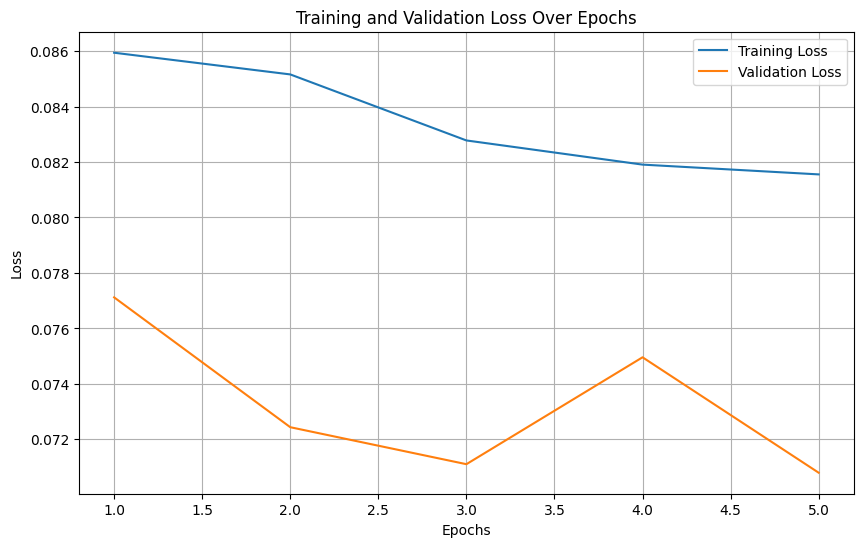

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
import random

# Randomly select an index from the validation set
random_idx = random.choice(range(len(val_loader.dataset)))

# Get the image and its corresponding mask from the validation set
image, mask = val_loader.dataset[random_idx]  # Example index from validation set
image = image.unsqueeze(0).to(device)
mask = mask.unsqueeze(0).to(device)


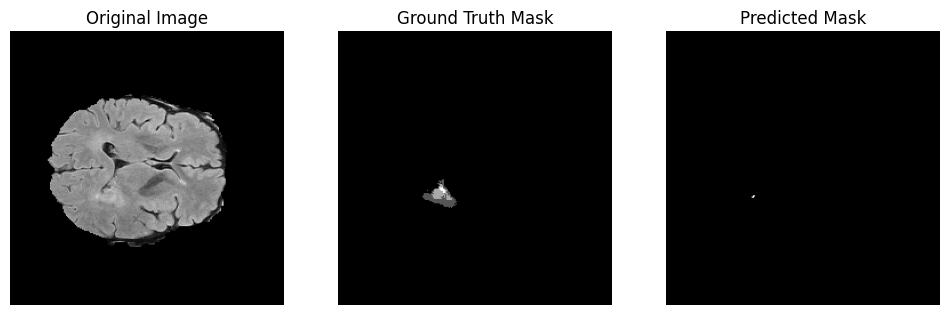

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_segmentation_example(image, mask, output, save_path="segmentation_example.png"):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Original Image
    axes[0].imshow(image[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Ground Truth Mask
    axes[1].imshow(mask[0].cpu().numpy(), cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(torch.argmax(output, dim=1)[0].cpu().numpy(), cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.savefig(save_path)
    plt.show()

# Example usage: After getting the model output during validation
image, mask = val_loader.dataset[random_idx]  # Example index from validation set
image = image.unsqueeze(0).to(device)
mask = mask.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image)

# Save and display the example
plot_segmentation_example(image, mask, output, save_path="segmentation_example.png")


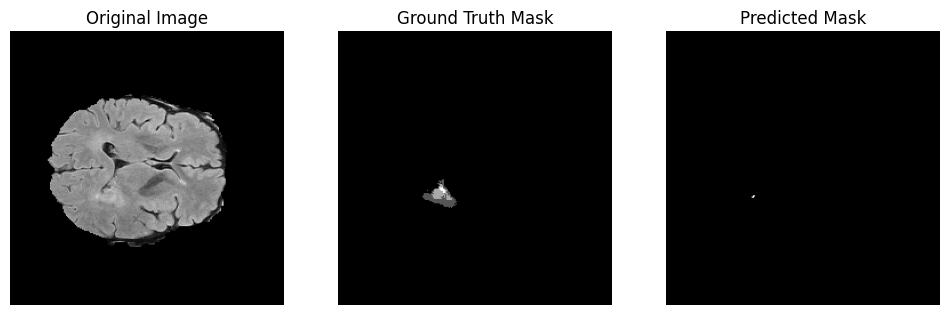

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_segmentation_example(image, mask, output, save_path="segmentation_example.png"):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Original Image
    axes[0].imshow(image[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Ground Truth Mask
    axes[1].imshow(mask[0].cpu().numpy(), cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(torch.argmax(output, dim=1)[0].cpu().numpy(), cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.savefig(save_path)
    plt.show()

# Example usage: After getting the model output during validation
image, mask = val_loader.dataset[random_idx]  # Example index from validation set
image = image.unsqueeze(0).to(device)
mask = mask.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image)

# Save and display the example
plot_segmentation_example(image, mask, output, save_path="segmentation_example.png")


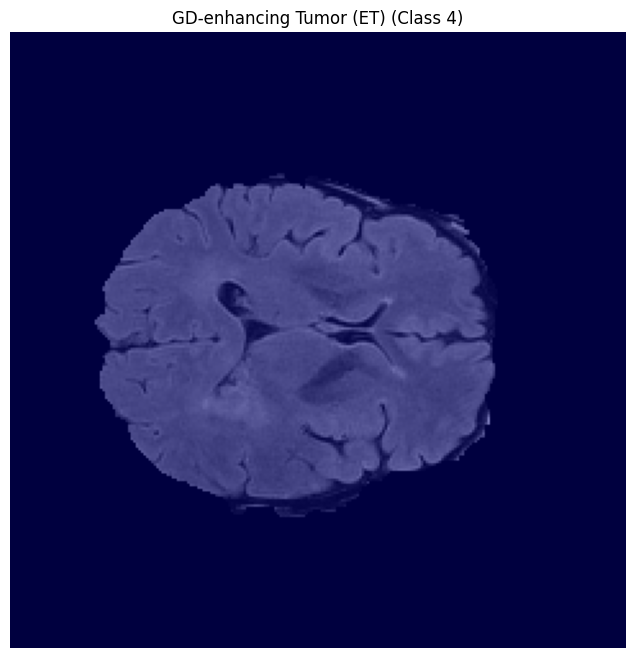

In [31]:
def overlay_segmentation(image, mask, output, class_idx, title="Segmentation Overlay"):
    output_mask = torch.argmax(output, dim=1).cpu().numpy()[0]
    mask = mask.cpu().numpy()[0]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image[0, 0].cpu().numpy(), cmap='gray')
    ax.imshow(output_mask == class_idx, cmap='jet', alpha=0.5)
    ax.set_title(f"{title} (Class {class_idx})")
    ax.axis('off')
    plt.show()

# Example usage:
overlay_segmentation(image, mask, output, class_idx=4, title="GD-enhancing Tumor (ET)")
